Comments

- Check if Random Forest (or any other model) is overfitting and explain why
- Fine-tune the hyperparameters of the best 2 performing "traditional" Machine Learning models
- Try to run the best 2 performing models without Sampling the data ! (you can shuffle it if and only if the temporal information has been taken featue engineered not to lose info aka. timestamp)
- Incorporate the temporal imformation in the training of the traditional ML models too - Ask Hindy, it is related to the Data part of which Vidur is in charge
- Add AUROC as a evaluation metrics
- Build an ensemble tree method alongside debuging  KNN, SVM, LightGBM, etc.
- Look at past papers on our dataset and see if they have used other kind of tradutional models and how they have evaluated/interpreted it all


### Data Preparation

Before training models, there are still a few things we should do. Let us check imbalance in our dataset classes, resample, and later shuffle teh data. 


In [1]:
# import our data
import pickle

# Load the data from the pickle file
with open("train_test_data.pkl", "rb") as f:
    X_train_final, X_test_final, y_train_encoded, y_test = pickle.load(f)

# Check the shapes of the imported data
print("X_train_final shape:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)
print("y_train_encoded shape:", y_train_encoded.shape)
print("y_test shape:", y_test.shape)

X_train_final shape: (73271, 68)
X_test_final shape: (18318, 68)
y_train_encoded shape: (73271,)
y_test shape: (18318,)


In [2]:
import numpy as np

# Check class distribution
unique_classes, class_counts = np.unique(y_train_encoded, return_counts=True)
class_distribution = dict(zip(unique_classes, class_counts))

print("Class Distribution in y_train_encoded:", class_distribution)

Class Distribution in y_train_encoded: {np.int64(0): np.int64(8145), np.int64(1): np.int64(25621), np.int64(2): np.int64(39505)}


As we can see, we need to oversample class 0 and downsample class 2. We do not use SMOTE or ASYN cause some dependency problems arise. 

In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import pandas as pd

# Step 1: Define the dataset
# Assuming X_train_final and y_train_encoded are your features and target
X_train = X_train_final.copy()
y_train = y_train_encoded.copy()

print("Original class distribution:")
print(Counter(y_train))  # Check initial distribution

# Step 2: Identify classes and their counts
classes, counts = np.unique(y_train, return_counts=True)
max_count = counts.max()  # Count of the majority class

# Step 3: Initialize placeholders for synthetic samples
X_synthetic = []
y_synthetic = []

# Step 4: Oversample each minority class
k_neighbors = 5  # Number of neighbors for interpolation
for cls, count in zip(classes, counts):
    if count < max_count:  # Only oversample classes smaller than the majority class
        n_samples_to_generate = max_count - count  # Number of synthetic samples needed
        X_minority = X_train[y_train == cls]

        # Use NearestNeighbors to find neighbors in the minority class
        nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(X_minority)
        indices = nbrs.kneighbors(X_minority, return_distance=False)

        # Generate synthetic samples
        synthetic_samples = []
        for _ in range(n_samples_to_generate):
            idx = np.random.randint(0, X_minority.shape[0])  # Randomly pick a minority sample
            nn_idx = indices[idx][np.random.randint(1, k_neighbors)]  # Pick one of its neighbors
            diff = X_minority[nn_idx] - X_minority[idx]  # Difference vector
            synthetic_sample = X_minority[idx] + np.random.rand() * diff  # Interpolation
            synthetic_samples.append(synthetic_sample)

        synthetic_samples = np.array(synthetic_samples)

        # Append synthetic samples and labels to placeholders
        X_synthetic.append(synthetic_samples)
        y_synthetic.append(np.full(n_samples_to_generate, cls))

# Step 5: Combine synthetic samples with the original dataset
X_synthetic = np.vstack(X_synthetic) if X_synthetic else np.empty((0, X_train.shape[1]))
y_synthetic = np.hstack(y_synthetic) if y_synthetic else np.empty((0,))

X_train_balanced = np.vstack([X_train, X_synthetic])
y_train_balanced = np.hstack([y_train, y_synthetic])

# Step 6: Verify the new class distribution
print("\nBalanced class distribution:")
print(Counter(y_train_balanced))

# Step 7: Output shapes
print("\nBalanced dataset shapes:")
print(f"Features shape: {X_train_balanced.shape}")
print(f"Target shape: {y_train_balanced.shape}")

Original class distribution:
Counter({np.int64(2): 39505, np.int64(1): 25621, np.int64(0): 8145})

Balanced class distribution:
Counter({np.int64(2): 39505, np.int64(0): 39505, np.int64(1): 39505})

Balanced dataset shapes:
Features shape: (118515, 68)
Target shape: (118515,)


In [4]:
from sklearn.utils import shuffle

# Combine features and labels into a single dataset for shuffling
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

# Verify the shapes after shuffling
print("Shuffled dataset shapes:")
print(f"Features shape: {X_train_balanced.shape}")
print(f"Target shape: {y_train_balanced.shape}")



Shuffled dataset shapes:
Features shape: (118515, 68)
Target shape: (118515,)


### Baseline Models

- Logistic Regression
- LightGBM
- XGBoost
- random Forest (not used because lacks explanability)
- SVM (c.f. Raph's paper)

1. Logistic Regression

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.48      0.42      0.45      7953
     Class 1       0.42      0.38      0.40      7854
     Class 2       0.49      0.59      0.53      7896

    accuracy                           0.46     23703
   macro avg       0.46      0.46      0.46     23703
weighted avg       0.46      0.46      0.46     23703



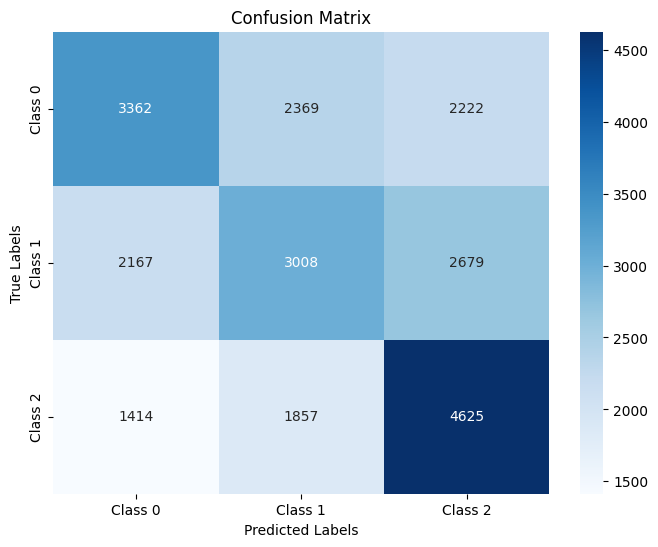

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42
)

# Step 2: Train the Logistic Regression model
logreg = LogisticRegression(
    solver='lbfgs',  # Efficient for small and medium datasets
    multi_class='multinomial',  # Multinomial for multi-class classification
    max_iter=1000,  # Higher iterations to ensure convergence
    random_state=42
)
logreg.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = logreg.predict(X_val)

# Step 4: Evaluate the model

# Classification Report
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=["Class 0", "Class 1", "Class 2"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

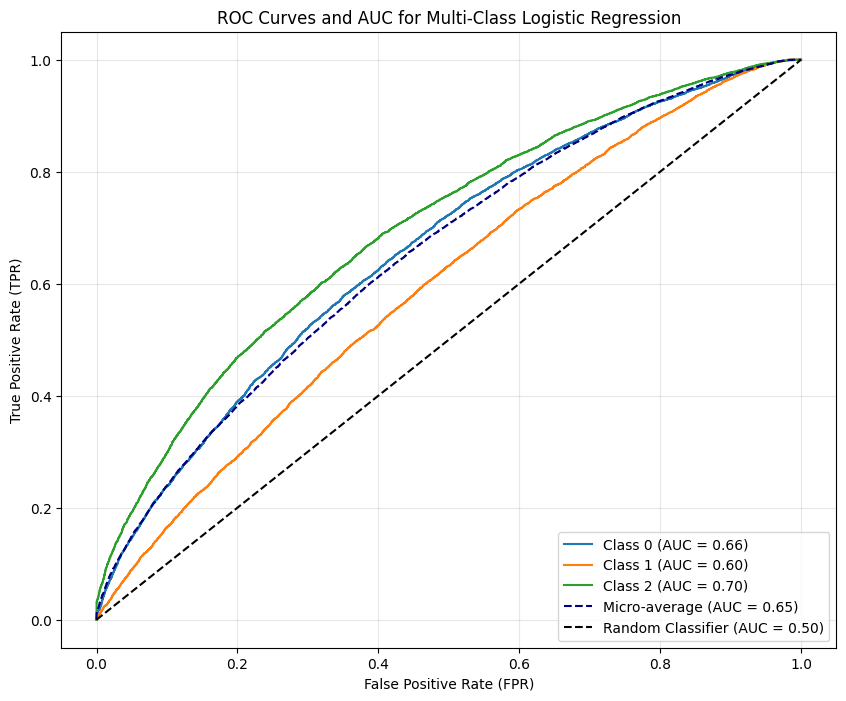

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels (required for multi-class ROC)
y_val_binarized = label_binarize(y_val, classes=[0, 1, 2])
n_classes = y_val_binarized.shape[1]

# Fit a one-vs-rest classifier (assuming Logistic Regression is used)
ovr_classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
ovr_classifier.fit(X_train, label_binarize(y_train, classes=[0, 1, 2]))
y_pred_proba = ovr_classifier.decision_function(X_val)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Multi-Class Logistic Regression")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

2. LightGBM

In [7]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Initialize lists to store scores and predictions
cv_scores = []
all_predictions = []
all_true_values = []

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store predictions and probabilities for each fold
fold_predictions = []
fold_probabilities = []
fold_true_values = []
fold_differences = []

# For storing confusion matrices
all_conf_matrices = []

# Perform 10-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"\nFold {fold + 1}/10")
    
    # Split data
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train[val_idx]
    y_val_fold = y_train[val_idx]
    
    # Initialize and train model
    lgbm_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_train)),
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        max_depth=4,
        feature_fraction=0.7,
        bagging_fraction=0.7,
        bagging_freq=5,
        min_child_samples=30,   
        reg_alpha=0.1,             
        reg_lambda=0.1,          
        min_split_gain=0.1 
    )
    

    # Train the model
    lgbm_model.fit(X_train_fold, y_train_fold,
        eval_set=[(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)],
        eval_metric='multi_logloss',
        eval_names=['train', 'valid'],
        ) 
    train_acc = accuracy_score(y_train_fold, lgbm_model.predict(X_train_fold))
    val_acc = accuracy_score(y_val_fold, lgbm_model.predict(X_val_fold))
    fold_differences.append(train_acc - val_acc)
    print(f"\nFold {fold + 1} Accuracies:")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Difference: {train_acc - val_acc:.4f}")
    
    # Make predictions
    fold_pred = lgbm_model.predict(X_val_fold)
    fold_prob = lgbm_model.predict_proba(X_val_fold)
    
    # Store predictions and true values
    fold_predictions.append(fold_pred)
    fold_probabilities.append(fold_prob)
    fold_true_values.append(y_val_fold)
    
    # Calculate and store accuracy
    accuracy = accuracy_score(y_val_fold, fold_pred)
    cv_scores.append(accuracy)
    
    # Store confusion matrix
    conf_matrix = confusion_matrix(y_val_fold, fold_pred)
    all_conf_matrices.append(conf_matrix)
    
    # Print fold results
    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val_fold, fold_pred, target_names=["Class 0", "Class 1", "Class 2"]))

# Print overall results
print("\nDifferences across folds:")
for i, diff in enumerate(fold_differences, 1):
    print(f"Fold {i} difference: {diff:.4f}")
print(f"\nAverage difference: {np.mean(fold_differences):.4f}")
print(f"Standard deviation of differences: {np.std(fold_differences):.4f}")

print("\nOverall Cross-Validation Results:")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")



Fold 1/10
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17340
[LightGBM] [Info] Number of data points in the train set: 85330, number of used features: 68
[

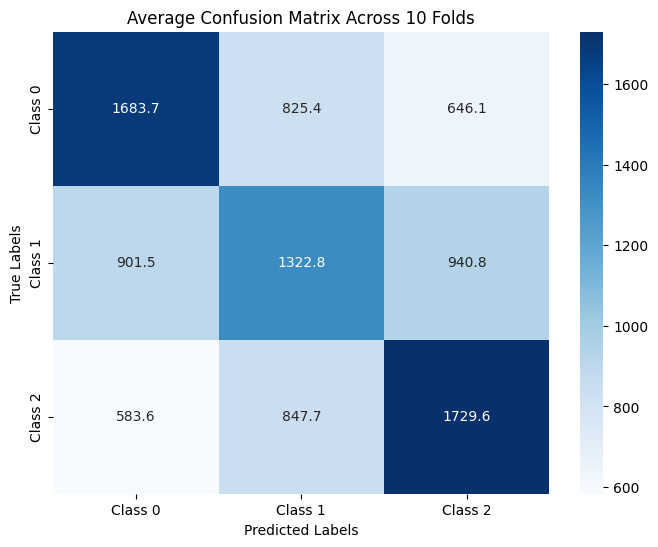

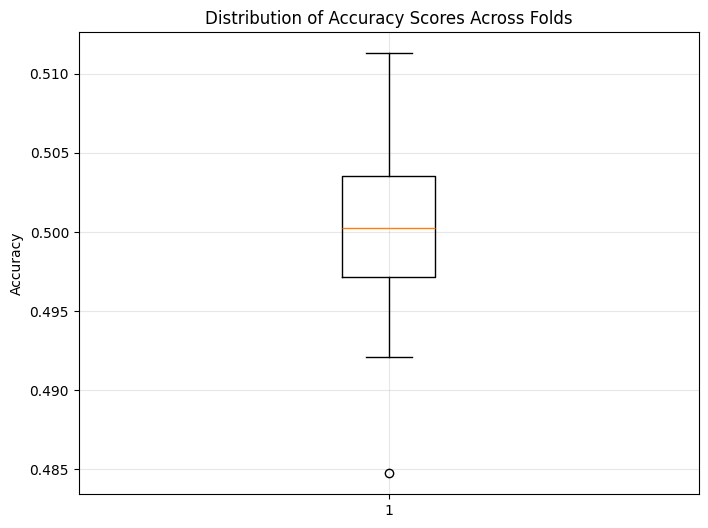

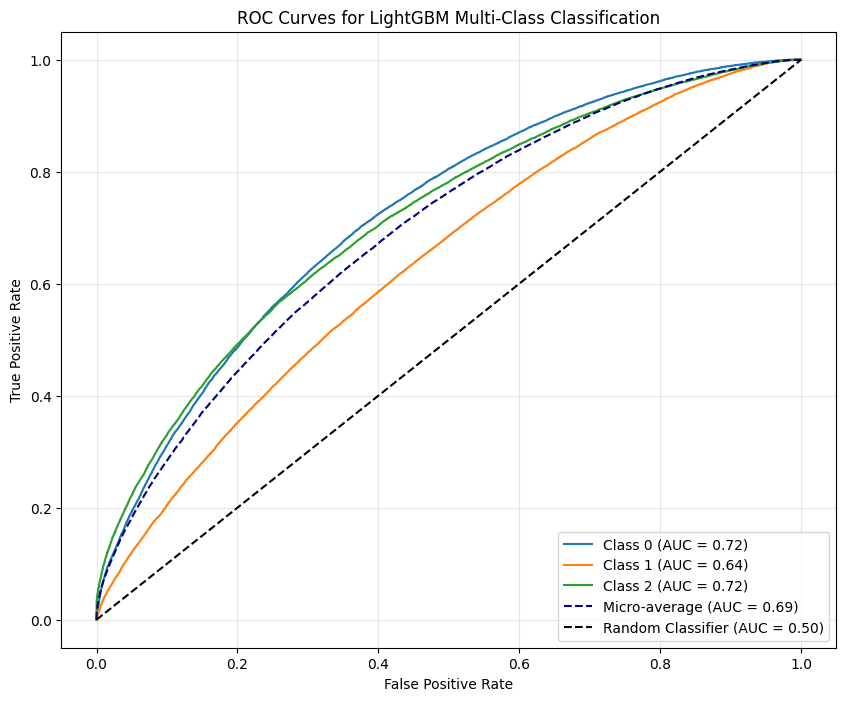

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17340
[LightGBM] [Info] Number of data points in the train set: 94812, number of used features: 68
[LightGBM] [

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Plot average confusion matrix
avg_conf_matrix = np.mean(all_conf_matrices, axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt='.1f', cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Average Confusion Matrix Across 10 Folds")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot accuracy distribution
plt.figure(figsize=(8, 6))
plt.boxplot(cv_scores)
plt.title("Distribution of Accuracy Scores Across Folds")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.show()

# Get all predictions and true values across 10 folds
all_probabilities = np.vstack([prob for prob in fold_probabilities])
all_true_values = np.concatenate(fold_true_values)

# Binarize the true values
y_true_binarized = label_binarize(all_true_values, classes=[0, 1, 2])
n_classes = y_true_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Calculate ROC curves for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], all_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), all_probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC curves for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], 
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
         linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for LightGBM Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# After cross-validation, we can evaluate on the held-out validation set
final_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_train)),
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        max_depth=4,
        feature_fraction=0.7,
        bagging_fraction=0.7,
        bagging_freq=5,
        min_child_samples=30,   
        reg_alpha=0.1,             
        reg_lambda=0.1,          
        min_split_gain=0.1 
    )
final_model.fit(X_train, y_train)
val_predictions = final_model.predict(X_val)
print("\nFinal Validation Set Performance:")
print(classification_report(y_val, val_predictions, target_names=["Class 0", "Class 1", "Class 2"]))


XGBoost

Training XGBoost model...

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.65      0.72      0.69      7953
     Class 1       0.54      0.49      0.52      7854
     Class 2       0.58      0.57      0.58      7896

    accuracy                           0.60     23703
   macro avg       0.59      0.60      0.59     23703
weighted avg       0.59      0.60      0.59     23703



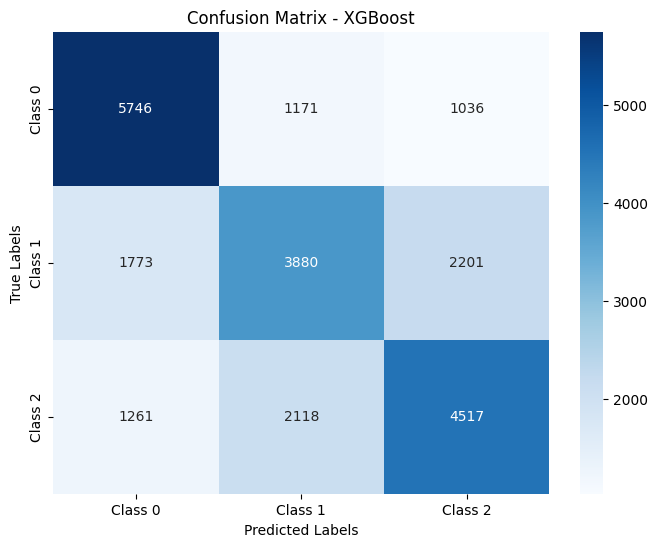

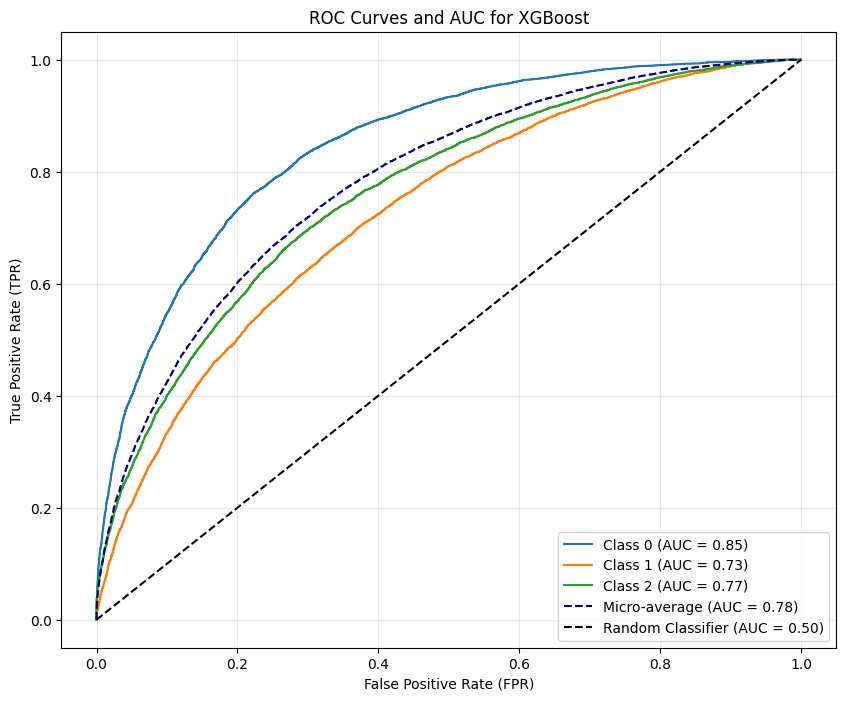

In [9]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Train XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # For multi-class classification with probabilities
    num_class=3,                # Specify number of classes
    eval_metric='mlogloss',     # Multi-class log loss as evaluation metric
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Step 2: Make predictions
y_pred = xgb_model.predict(X_val)
y_pred_proba = xgb_model.predict_proba(X_val)

# Step 3: Classification Report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=["Class 0", "Class 1", "Class 2"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Step 5: ROC and AUC
y_val_binarized = label_binarize(y_val, classes=[0, 1, 2])
n_classes = y_val_binarized.shape[1]

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for XGBoost")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()



Random Forest

Training Random Forest model...

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.84      0.91      0.88      7953
     Class 1       0.67      0.71      0.69      7854
     Class 2       0.70      0.61      0.65      7896

    accuracy                           0.74     23703
   macro avg       0.74      0.74      0.74     23703
weighted avg       0.74      0.74      0.74     23703



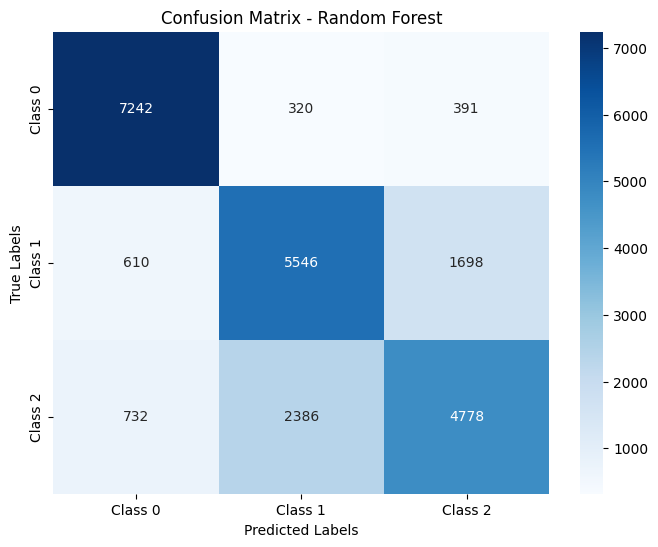

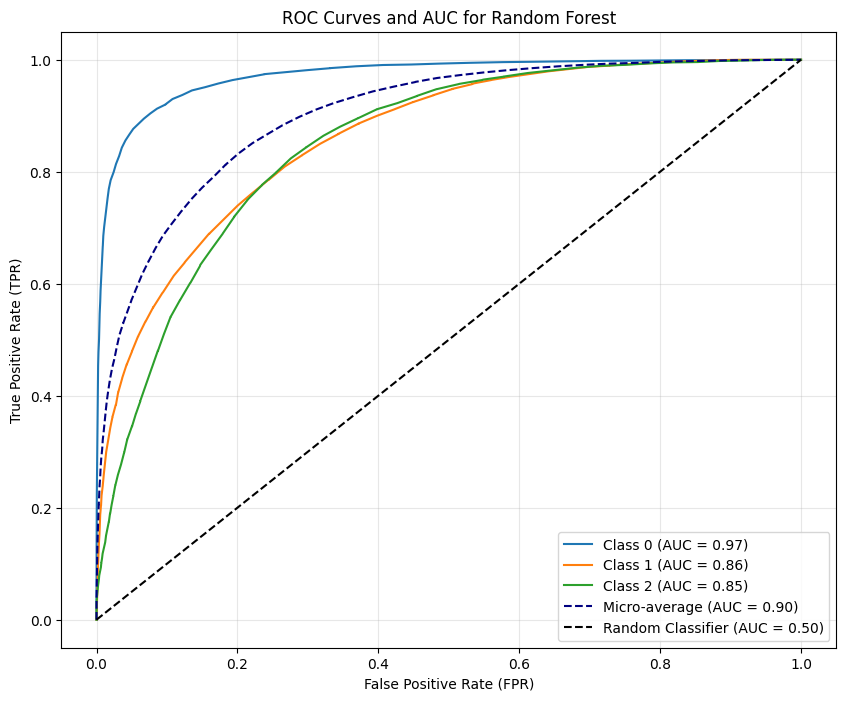

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=80,    # Number of trees in the forest
    random_state=42,     # Ensure reproducibility
    max_depth=None,      # Allow trees to grow fully
    class_weight="balanced"  # Handle class imbalance
)

rf_model.fit(X_train, y_train)

# Step 2: Make predictions
y_pred = rf_model.predict(X_val)
y_pred_proba = rf_model.predict_proba(X_val)

# Step 3: Classification Report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=["Class 0", "Class 1", "Class 2"]))

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Step 5: ROC and AUC
y_val_binarized = label_binarize(y_val, classes=[0, 1, 2])
n_classes = y_val_binarized.shape[1]

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Random Forest")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [34]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Initialize lists to store scores and predictions
cv_scores = []
fold_predictions = []
fold_probabilities = []
fold_true_values = []
fold_differences = []
all_conf_matrices = []

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform 10-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"\nFold {fold + 1}/10")
    
    # Split data
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train[val_idx]
    y_val_fold = y_train[val_idx]
    
    # Initialize and train model
    rf_model = RandomForestClassifier(
        n_estimators=120,
        max_depth=30,
        max_features='sqrt',   # Number of trees in the forest
        random_state=42,     # Ensure reproducibility 
        class_weight="balanced"  # Handle class imbalance
    )
    
    # Train the model on the FOLD training data (not full training set)
    rf_model.fit(X_train_fold, y_train_fold)  # Changed from X_train, y_train
    
    # Calculate accuracies
    train_acc = accuracy_score(y_train_fold, rf_model.predict(X_train_fold))
    val_acc = accuracy_score(y_val_fold, rf_model.predict(X_val_fold))
    fold_differences.append(train_acc - val_acc)
    
    print(f"\nFold {fold + 1} Accuracies:")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Difference: {train_acc - val_acc:.4f}")
    
    # Make predictions using rf_model (not lgbm_model)
    fold_pred = rf_model.predict(X_val_fold)
    fold_prob = rf_model.predict_proba(X_val_fold)
    
    # Store predictions and true values
    fold_predictions.append(fold_pred)
    fold_probabilities.append(fold_prob)
    fold_true_values.append(y_val_fold)
    
    # Calculate and store accuracy
    accuracy = accuracy_score(y_val_fold, fold_pred)
    cv_scores.append(accuracy)
    
    # Store confusion matrix
    conf_matrix = confusion_matrix(y_val_fold, fold_pred)
    all_conf_matrices.append(conf_matrix)
    
    # Print fold results
    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val_fold, fold_pred, target_names=["Class 0", "Class 1", "Class 2"]))

# Print overall results
print("\nDifferences across folds:")
for i, diff in enumerate(fold_differences, 1):
    print(f"Fold {i} difference: {diff:.4f}")
print(f"\nAverage difference: {np.mean(fold_differences):.4f}")
print(f"Standard deviation of differences: {np.std(fold_differences):.4f}")

print("\nOverall Cross-Validation Results:")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")


Fold 1/10

Fold 1 Accuracies:
Training Accuracy: 0.9990
Validation Accuracy: 0.7193
Difference: 0.2796
Fold 1 Accuracy: 0.7193

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.82      0.88      0.85      6406
     Class 1       0.66      0.67      0.66      6339
     Class 2       0.66      0.60      0.63      6218

    accuracy                           0.72     18963
   macro avg       0.71      0.72      0.72     18963
weighted avg       0.72      0.72      0.72     18963


Fold 2/10

Fold 2 Accuracies:
Training Accuracy: 0.9989
Validation Accuracy: 0.7129
Difference: 0.2860
Fold 2 Accuracy: 0.7129

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.88      0.85      6331
     Class 1       0.64      0.67      0.65      6248
     Class 2       0.66      0.60      0.63      6384

    accuracy                           0.71     18963
   macro avg       0.71      0.71      0.71

Is this overfitting? 

Support Vector Machine (SVM)



SGDClassifier (approx of SVM with stochastic graident descent)

In [ ]:
from sklearn.linear_model import SGDClassifier

print("Training SGDClassifier (approximate SVM) model...")
sgd_clf = SGDClassifier(loss="hinge", max_iter=5000, random_state=42)
sgd_clf.fit(X_train, y_train)

y_pred = sgd_clf.predict(X_val)
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=["Class 0", "Class 1", "Class 2"]))

Training SGDClassifier (approximate SVM) model...

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.47      0.46      0.46      7953
     Class 1       0.36      0.26      0.31      7854
     Class 2       0.45      0.59      0.51      7896

    accuracy                           0.44     23703
   macro avg       0.43      0.44      0.43     23703
weighted avg       0.43      0.44      0.43     23703




Training Set Results:
----------------------
Classification Report:

              precision    recall  f1-score   support

     Class 0       0.49      0.45      0.47     31552
     Class 1       0.41      0.39      0.40     31651
     Class 2       0.49      0.56      0.52     31609

    accuracy                           0.46     94812
   macro avg       0.46      0.46      0.46     94812
weighted avg       0.46      0.46      0.46     94812



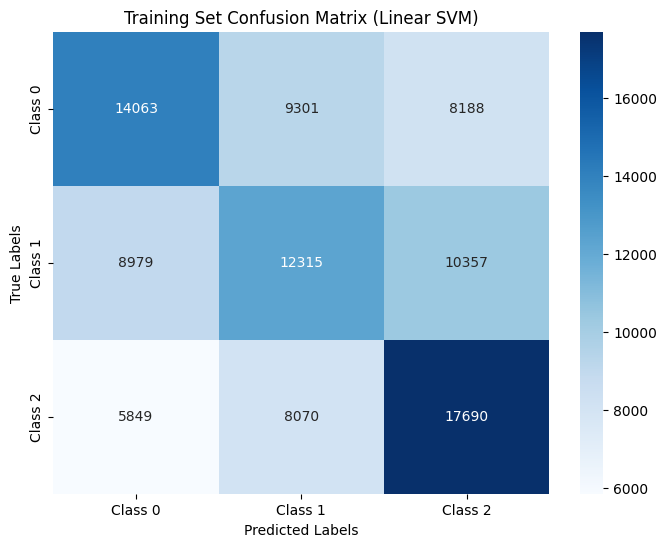

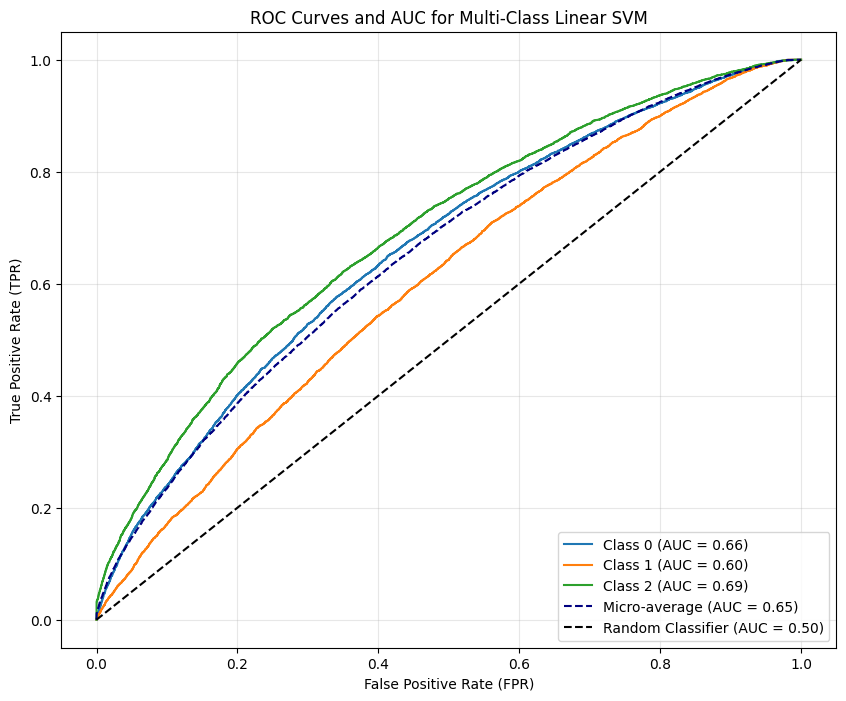


AUC Scores for each class:
--------------------------
Class 0: 0.6621
Class 1: 0.6030
Class 2: 0.6898
Micro-average: 0.6541


In [9]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Initialize Linear SVM model
base_svm = LinearSVC(
    random_state=42,
    C=1.0,  # Regularization parameter
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000  # Increase max iterations if needed
)

# Wrap the model with CalibratedClassifierCV to get probability estimates
svm_model = CalibratedClassifierCV(base_svm, cv=5)

# Train model
svm_model.fit(X_train, y_train)

# Make predictions
train_predictions = svm_model.predict(X_train)
val_predictions = svm_model.predict(X_val)

# Training Set Results
print("\nTraining Set Results:")
print("----------------------")
print("Classification Report:\n")
print(classification_report(y_train, train_predictions, target_names=["Class 0", "Class 1", "Class 2"]))

# Training Confusion Matrix
conf_matrix_train = confusion_matrix(y_train, train_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Class 0", "Class 1", "Class 2"], 
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Training Set Confusion Matrix (Linear SVM)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Get probabilities for ROC curve
y_pred_proba = svm_model.predict_proba(X_val)

# Binarize the target labels
y_val_binarized = label_binarize(y_val, classes=[0, 1, 2])
n_classes = y_val_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC curves for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], 
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
         linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

# Formatting the plot
plt.title('ROC Curves and AUC for Multi-Class Linear SVM')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Print AUC scores for each class
print("\nAUC Scores for each class:")
print("--------------------------")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.4f}")
print(f"Micro-average: {roc_auc['micro']:.4f}")

### Super Learners

- DNN
- etc.